# Interpreting A LightGBM Model With SHAP
-------
0. Introduction

1. Exploratory Data Analysis

2. Baseline Logistic Regression Model

3. Gradient Boosting Model With LightGBM

4. Intepreting The Model With Shapely

5. Conclussions

-----------


## Introduction
-----------


Data from [Kaggle](https://www.kaggle.com/teejmahal20/airline-passenger-satisfaction)


## Exploratory Data Analysis
------------------

In [1]:
import pandas as pd
import seaborn as sns

Read article to read from Google Cloud Storage [here](https://markusodenthal.medium.com/the-easy-way-to-read-files-from-google-cloud-storage-with-pandas-or-dask-3a424b71af14) and getting started with authentication [here](https://cloud.google.com/docs/authentication/getting-started)

In [45]:
train_df = pd.read_parquet("gs://harmon_mlprojects/airline/train.parquet",
                        storage_options={"token":"credentials.json"})

In [46]:
test_df= pd.read_parquet("gs://harmon_mlprojects/airline/test.parquet",
                        storage_options={"token":"credentials.json"})

In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 103904 non-null  int64  
 1   Gender                             103904 non-null  object 
 2   Customer Type                      103904 non-null  object 
 3   Age                                103904 non-null  int64  
 4   Type of Travel                     103904 non-null  object 
 5   Class                              103904 non-null  object 
 6   Flight Distance                    103904 non-null  int64  
 7   Inflight wifi service              103904 non-null  int64  
 8   Departure/Arrival time convenient  103904 non-null  int64  
 9   Ease of Online booking             103904 non-null  int64  
 10  Gate location                      103904 non-null  int64  
 11  Food and drink                     1039

First convert the spaces to _

In [49]:
train_df.columns = [col.replace(" ", "_") for col in train_df.columns]

The look at the number of nulls in each field

In [73]:
train_df.isnull().sum(axis = 0)

id                                     0
Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
target          

Really only one feature with nulls, we'll wait for EDA to decide how we want to handle missing values.

Look at the target variable values

In [52]:
train_df["satisfaction"].unique()

array(['neutral or dissatisfied', 'satisfied'], dtype=object)

Will have to do something to deal with not applicable in Inflight Wifi:

<AxesSubplot:>

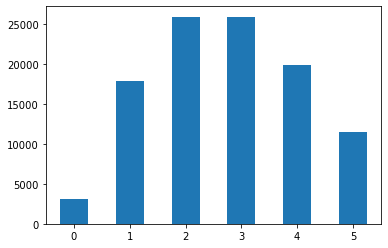

In [66]:
train_df["Inflight_wifi_service"].value_counts().sort_index().plot(kind="bar",rot=0)

Declare which variables are categorical, numerical and ordinal:

In [68]:
cat_feats = ["Gender","Customer_Type","Type_of_Travel","Class"]

num_feats = ["Departure_Delay_in_Minutes",
             "Age",
             "Arrival_Delay_in_Minutes",
             "Flight_Distance"]

The ordinal variables are then the ones that are not categorial or numerical:

In [67]:
ord_feats = [col for col in train_df.columns if col not in ["satisfaction","target"] 
                                             and col not in cat_feats
                                             and col not in num_feats]

Now want to label the target class as 0 or 1. 1 being statisfied and 0 being unsatisfied.  Use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) do so:

In [70]:
from sklearn.preprocessing import LabelEncoder

# first fit the encoder
labeler = LabelEncoder().fit(train_df["satisfaction"])

# then use it to transform the satisfaction column
train_df = train_df.assign(target=labeler.transform(train_df["satisfaction"]))
test_df = test_df.assign(target=labeler.transform(test_df["satisfaction"]))

We can always see the label for the classes 1 or 0

In [74]:
labeler.inverse_transform([1])

array(['satisfied'], dtype=object)

In [75]:
labeler.inverse_transform([0])

array(['neutral or dissatisfied'], dtype=object)

Now we want to see how many datapoints are in each class:

<AxesSubplot:title={'center':'Class Counts'}>

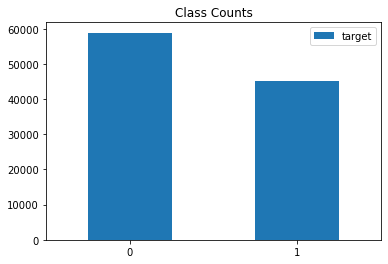

In [76]:
(train_df["target"].value_counts()
                   .plot(kind="bar", 
                         title="Class Counts", 
                         legend=True,rot=0))

Now we want to convert the datafame into its long form so we can more easily use it with [Seaborn](https://seaborn.pydata.org/) for plotting and understanding the relation of each feature with the target variables. We break the the dataframes into their features categories, i.e. categorical, ordinal or numerical:

In [77]:
long_num_df = train_df[num_feats + ["target"]].melt(id_vars="target")
long_ord_df = train_df[ord_feats + ["target"]].melt(id_vars="target")
long_cat_df = train_df[cat_feats + ["target"]].melt(id_vars="target")

We'll use different plots based on the type of feature is. We'll first start out with numerical variables:

### Numerical Variables
-------

We first plot the numerical features as box plots to see if there is any clear seperation point in each of features value between classes.

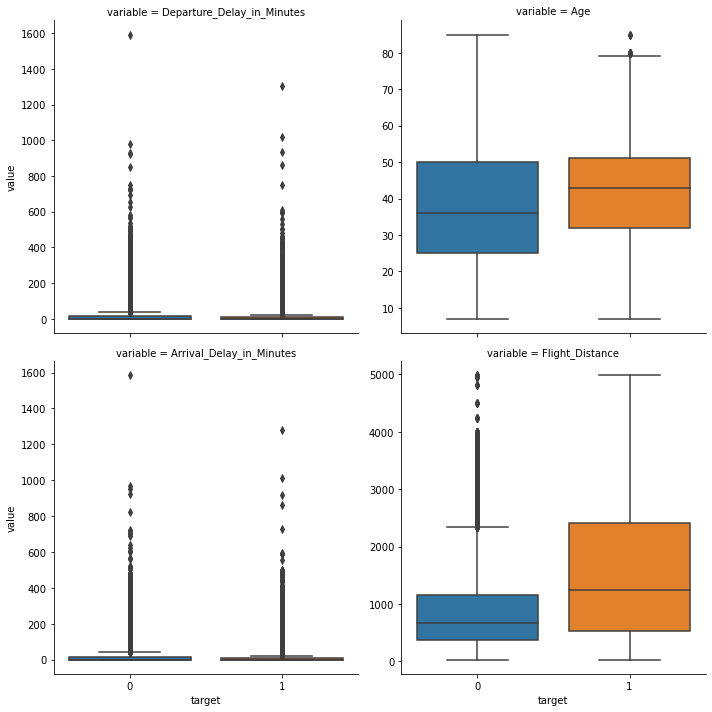

In [16]:
sns.catplot(
    data=long_num_df, x='target', y='value',
    col='variable', kind='box', col_wrap=2, 
    sharey=False
)

It looks like satisfied customers tend to be slightly older and on longer flights than unsatisfied customers.

The Departure and Arrivals Delays tons of outliers meaning we should probably look to use median for imputing missing values over the mean. Let's look at scatter plot relationships for correlations in continuous features as well as the features underlying distribution:

In [183]:
# g = sns.FacetGrid(long_num_df, col='variable',col_wrap=2)
# g.map_dataframe(sns.regplot, y='target', x='value', logistic=True)

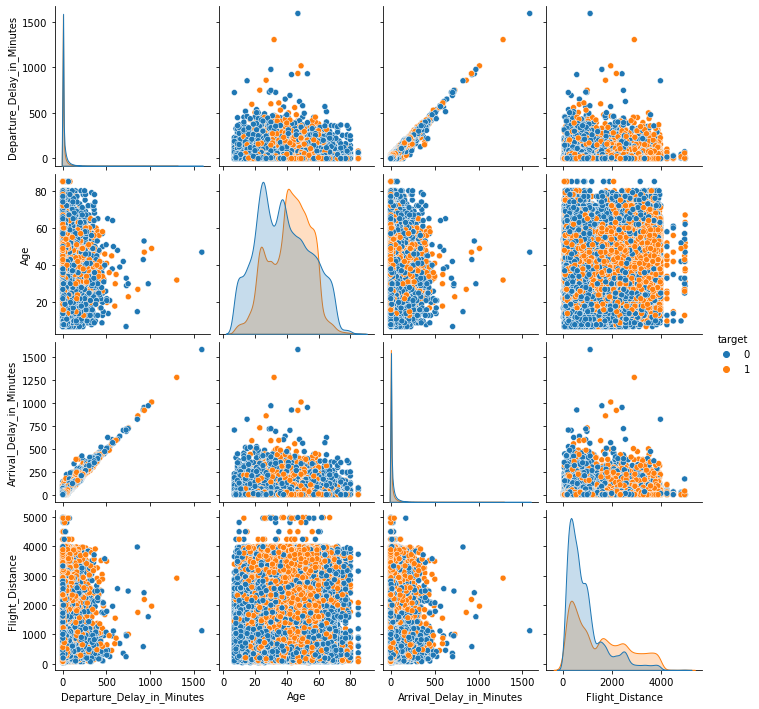

In [17]:
sns.pairplot(train_df[num_feats+["target"]],
             hue='target')

In [106]:
import numpy as np

log_df = (train_df.assign(Arrival_Delay_in_Minutes=np.log(0.1 + train_df["Arrival_Delay_in_Minutes"]))
                  .assign(Departure_Delay_in_Minutes=np.log(0.1 + train_df["Departure_Delay_in_Minutes"])))

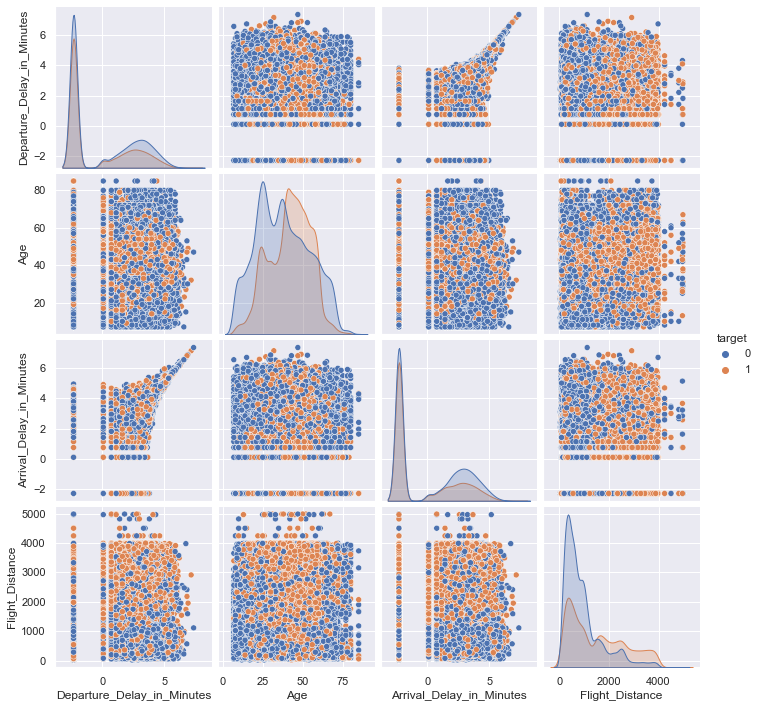

In [107]:
sns.pairplot(log_df[num_feats+["target"]],
             hue='target')

Pretty strong linear relationship between delay times.. can probably use linear regresssion to impute missing values or drop the one with missing values, however, they dnt have to see 

So far use: Age, Flight_Distance

In [81]:
long_num_df

,target,variable,value
0,0,Departure_Delay_in_Minutes,25.0
1,0,Departure_Delay_in_Minutes,1.0
2,1,Departure_Delay_in_Minutes,0.0
3,0,Departure_Delay_in_Minutes,11.0
4,1,Departure_Delay_in_Minutes,0.0
...,...,...,...
415611,0,Flight_Distance,192.0
415612,1,Flight_Distance,2347.0
415613,0,Flight_Distance,1995.0
415614,0,Flight_Distance,1000.0


KeyboardInterrupt: 

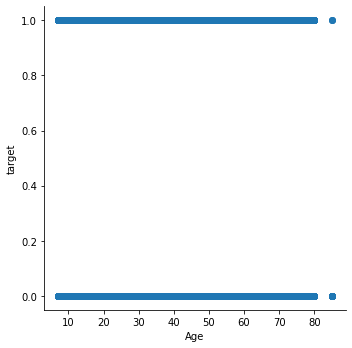

In [82]:
g = sns.lmplot(data=train_df, x="Age", y="target", logistic=True)

### Ordinal Variables

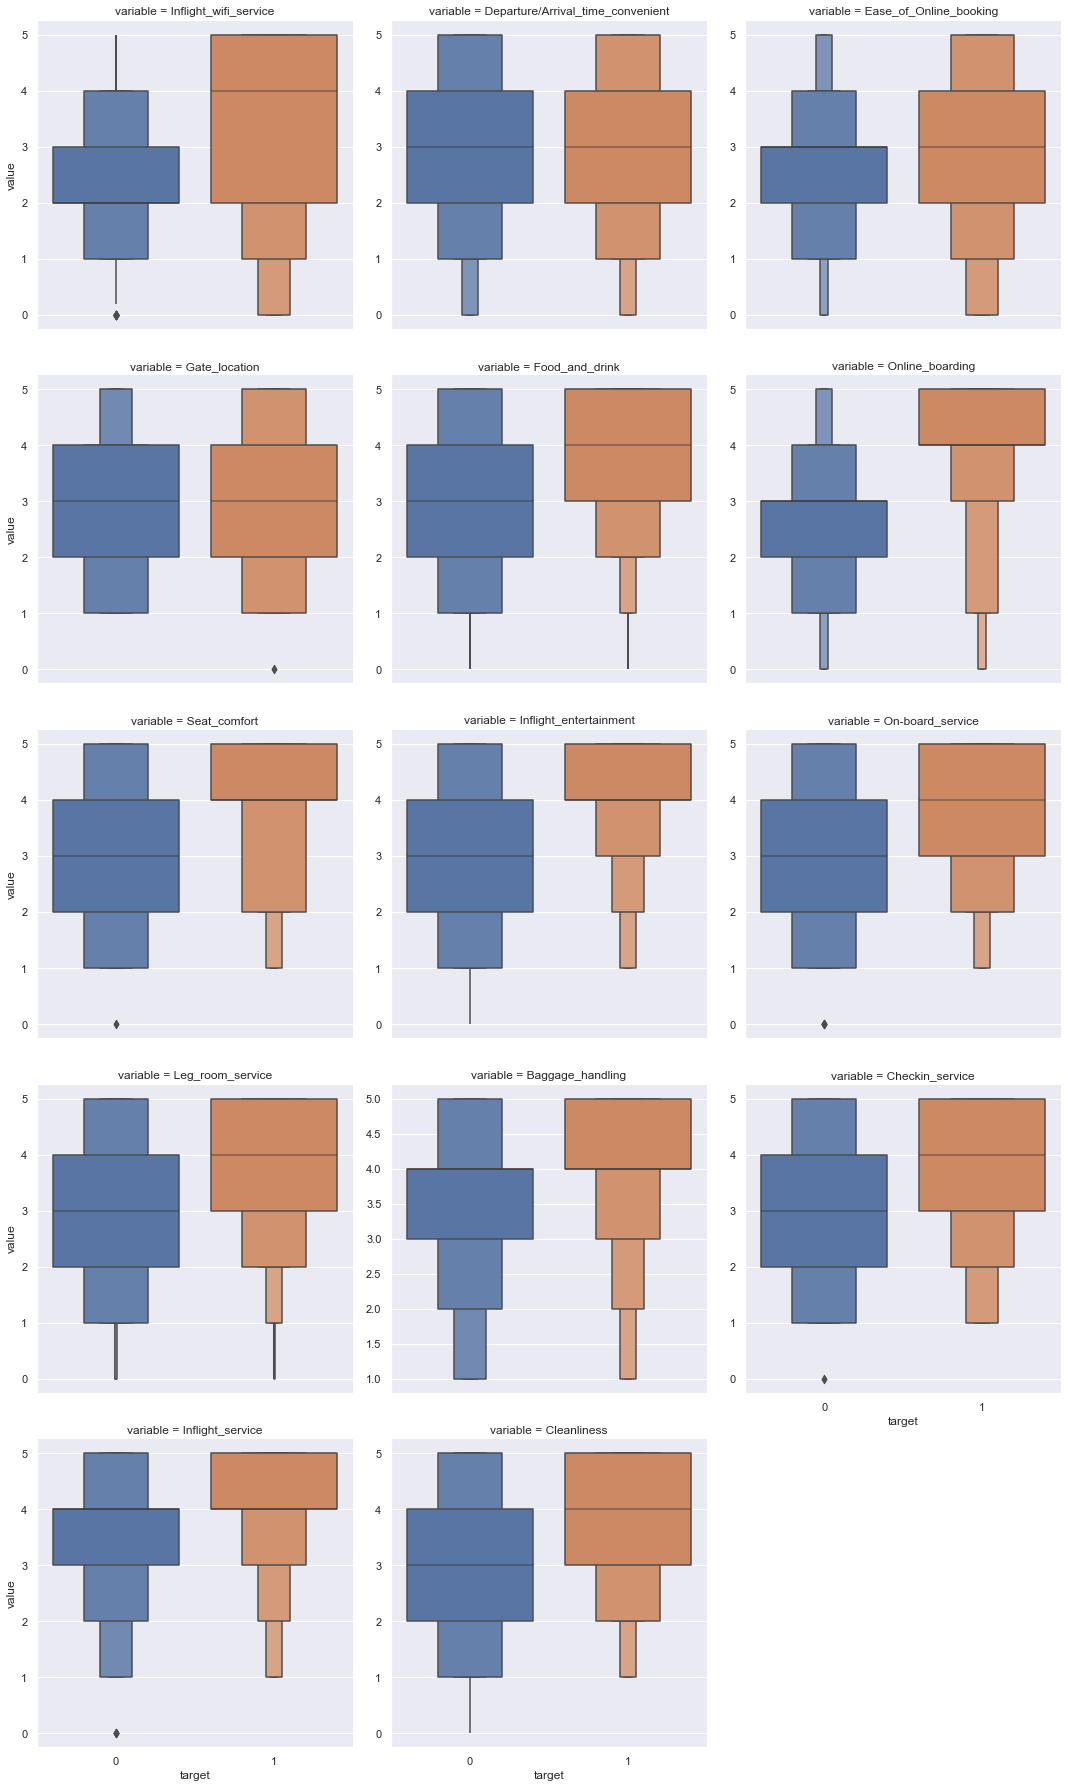

In [103]:
sns.catplot(
    data=long_ord_df, x='target', y='value',
    col='variable', kind='boxen', col_wrap=3, 
    sharey=False
)

### Categorical Variables

/Users/mikeharmon/opt/miniconda3/envs/air/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)
/Users/mikeharmon/opt/miniconda3/envs/air/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)
/Users/mikeharmon/opt/miniconda3/envs/air/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)
/Users/mikeharmon/opt/miniconda3/envs/air/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try countplot
  warnings.warn(msg, UserWarning)


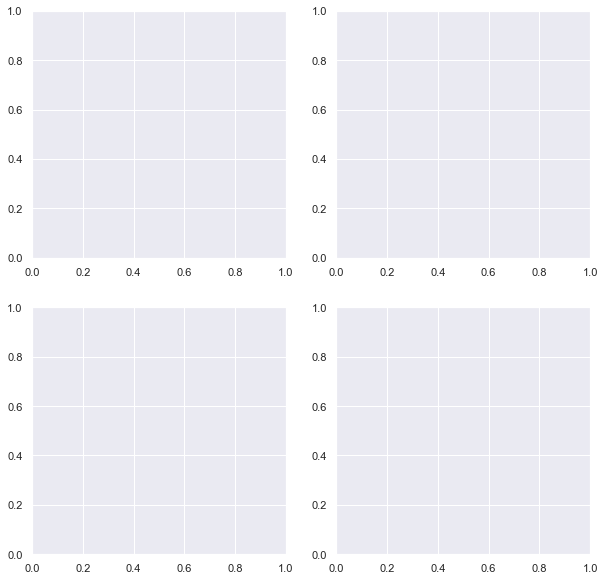

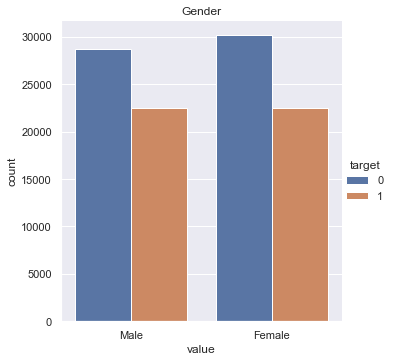

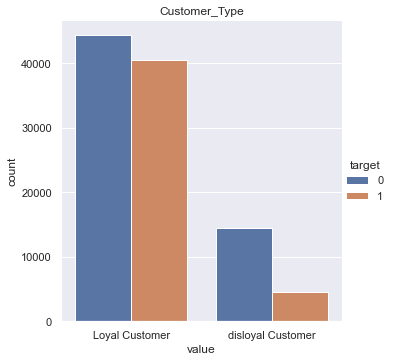

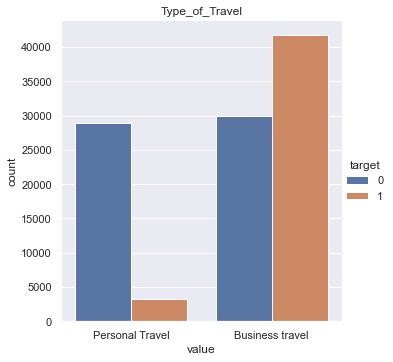

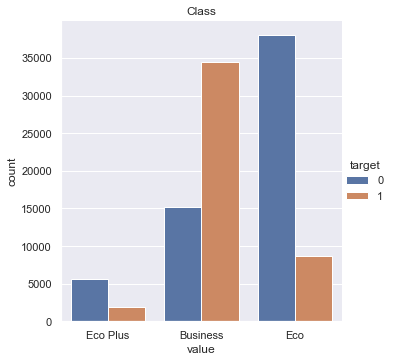

In [101]:
ax_ids = [[0,0], [0,1], [1,0], [1,1]]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for var, ax_id in zip(long_cat_df.variable.unique(), ax_ids):
    g = sns.catplot(data=long_cat_df.query(f"variable=='{var}'"),
                                x='value', 
                                hue="target",
                                kind='count',
                                ax=axs[ax_id])
    g.set_titles(f"{var} count")
    plt.title(f"{var}")

## Baseline Logistic Regression Model
-----------------

See that a basic Model could include:
    
    
1. Numerical Variables
    - Flight_Distance
    - Age

2. Ordinal Variables
    - Inflight_wifi_service
    - Ease_of_Online_booking
    - Food_and_drink
    - Online_boarding
    - Seat_comfort
    - Inflight_entertainment
    - On-board_service
    - Leg_room_service
    - Baggage_handling
    - Checkin_service
    - Inflight_service
    - Cleanlines

3. Categorial Variables
    - Type_Of_Travel
    - Class
    - Customer_Type

    
    

In [284]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from typing import List

class LRTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, 
                 num_feats: List[str], 
                 ord_feats: List[str], 
                 cat_feats: List[str]
        ):
        self.num_feats = num_feats
        self.ord_feats = ord_feats
        self.cat_feats = cat_feats
        
        self.col_transformer = ColumnTransformer(
                                transformers=[('stdscaler', StandardScaler(), self.num_feats + self.ord_feats),
                                              ('onehot',OneHotEncoder(drop='first'), self.cat_feats)],
                                remainder="drop")

    def fit(self, X: pd.DataFrame, y: pd.Series=None) -> LRTransformer:
        self.scaler = self.col_transformer.fit(X,y)
        
        return self
        
    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> np.array:
        return self.col_transformer.transform(X)
        
    def get_features(self) -> List[str]:
        """
        See: https://katstam.com/regression-feature_importance/
        """
        one_hot_features = list(self.col_transformer
                                    .named_transformers_['onehot']
                                    .get_feature_names_out(input_features=base_cat))
        
        return self.num_feats + self.ord_feats + one_hot_features

In [285]:
base_num = ["Flight_Distance", "Age"]
base_cat = ["Type_of_Travel", "Class", "Customer_Type"]
base_ord = ord_feats.copy()
base_ord.remove("Gate_location")
base_ord.remove('Departure/Arrival_time_convenient')

In [286]:
lrt = LRTransformer(num_feats=base_num,cat_feats=base_cat,ord_feats=base_ord)

In [287]:
lrt.fit_transform(X.head(1))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [288]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import 

In [289]:
lr_pipe = Pipeline(steps=[("lrt", LRTransformer(num_feats=base_num,
                                                cat_feats=base_cat,
                                                ord_feats=base_ord)),
                          ("log_reg", LogisticRegression())])

In [290]:
lr_model = lr_pipe.fit(X,y)

In [291]:
scores = cross_validate(lr_pipe, X, y, cv=5, scoring=('precision', 'recall', 'roc_auc'))

In [292]:
print("Precision: ", scores["test_precision"].mean())
print("Recall: ", scores["test_recall"].mean())
print("ROC_AUC: ", scores["test_roc_auc"].mean())

Precision:  0.8680955105252158
Recall:  0.834891726818434
ROC_AUC:  0.92528586556235


## Gradient Boosting Model With LightGBM
--------------------

In [190]:
class LGBMTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_feats, ord_feats, cat_feats):
        self.num_feats = num_feats
        self.ord_feats = ord_feats
        self.cat_feats = cat_feats

    def fit(self, X, y=None):
        return self
        
    def transform(self, X,y=None):
        for feat in cat_feats:
            X.loc[:,feat] = X.loc[:,feat].astype("category")
        return X
        

In [200]:
cat_str = ",".join(base_cat)
cat_str

'Type_of_Travel,Class,Customer_Type'

In [308]:
lgb_pipe = Pipeline(steps=[("lgb_trasformer",LGBMTransformer(
                                                         num_feats=base_num,
                                                         ord_feats=base_ord,
                                                         cat_feats=base_cat
                                                        )),
                          ("lgb_model", lgb.LGBMClassifier(objective='binary'))])

In [309]:
lgb_model = lgb_pipe.fit(X,y)

In [310]:
scores = cross_validate(lgb_pipe, X, y, cv=5, scoring=('precision', 'recall', 'roc_auc'))

In [247]:
print("Precision: ", scores["test_precision"].mean())
print("Recall: ", scores["test_recall"].mean())
print("ROC_AUC: ", scores["test_roc_auc"].mean())

Precision:  0.9747873145749579
Recall:  0.9410327595780121
ROC_AUC:  0.9950298725840435


In [ ]:
importances = pd.DataFrame(data={
    'Attribute': lgb_model['lgb_trasformer'].get_features(),
    'Importance': lgb_trasformer['log_reg'].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

In [314]:
len(lgb_model["lgb_model"].feature_importances_)

22

In [315]:
lgb_model["lgb_model"].feature_importances_

array([  1, 200, 254, 184, 171, 131, 526,  62,  59, 152,  28, 163, 149,
       147,  74,  80, 169, 103, 138,  90,  33,  86], dtype=int32)

## Intepreting Models With SHAP
--------



https://slundberg.github.io/shap/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html

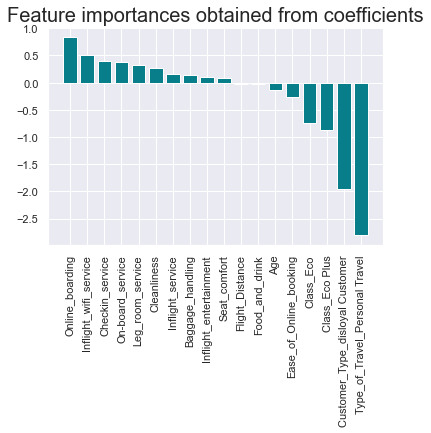

In [317]:
importances = pd.DataFrame(data={
    'Attribute': lr_model['lrt'].get_features(),
    'Importance': lr_model['log_reg'].coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()